## 2.3
Using the parameters from points 1 and 2, which of the following functional (PBE, PBEsol, RPBE, LDA) gives the most accurate estimation of the adsorption energy of H (with respect to H2 molecule)?

In [17]:
%%writefile ex2.py
import pickle
from ase.build import molecule
from ase.visualize import view
from ase.optimize import BFGS
from ase.parallel import parprint, paropen
from gpaw import GPAW, PW

energies = {}

for xc in ['LDA' , 'PBE' , 'PBEsol', 'RPBE']:
    for name in ['H2','H']: 
        system = molecule(name)
        system.center(vacuum=10)
        
        calc = GPAW(h=0.20,
                    mode=PW(750),
                    basis='sz(dzp)',
                    xc=xc,
                    symmetry={'point_group': False},
                    txt='unrelax-'+name+'-'+xc+'.txt'
                    )
        
        #Hund's rule?
        if name == 'H':
            calc.set(hund=True)
        
        system.calc = calc
        relax = BFGS(system,
                        trajectory='relax-' + name + '.traj',
                        logfile='relax-' + name + '.log')
        relax.run(fmax=0.05)
    
        energy = system.get_potential_energy()
        energies[(name, xc)] = energy
        parprint(name, energy)

    # Store energies dictionary for later
    with paropen('energies_ex2.pckl', 'wb') as f:
        pickle.dump(energies, f)
        

Overwriting ex2.py


In [18]:
!mq submit -R 24:1h ex2.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
14995823 ./ ex2.py 24:1h
1 task submitted


In [1]:
!mq ls

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
id       folder name                             res.         age state         time 
──────── ────── ──────────────────────────────── ───── ────────── ─────── ────────── 
14995313 ./     exam2b_supercell_1.py            24:2d 4:18:24:15 done       6:34:45 
14995809 ./     exam2b_supercell_1.py            24:2d 4:17:19:48 done       6:43:01 
14996

In [32]:
import pickle
with open('energies_ex2.pckl', 'rb') as f:
    energies = pickle.load(f) 
H2_LDA = energies['H2','LDA'] 
H_LDA = energies['H','LDA'] 

print('H2_LDA: {:.3f} eV\nH_LDA: {:.3f} eV'.format(H2_LDA, H_LDA))

H2_LDA: -6.704 eV
H_LDA: -0.900 eV


In [3]:
%%writefile exam2c_PBE.py
import pickle
from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW

k = 6
ecut = 600
a_Ru = 3.83
slab = fcc111('Ru', a=a_Ru, size=(2, 2, 3), vacuum=10.0, periodic=True)

# Use the FixAtoms constraint to disallow any movement during
# relaxation of any atoms that has the property tag > 1.
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

# Remember to visualize your structure
if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    add_adsorbate(slab=slab, adsorbate='H',
                  height=1.5, position='fcc')
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.

energies_slab = {}


# First we relax the slab
settings = {'h': 0.20,
            'mode': PW(ecut),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (k, k, 1),
            'symmetry': {'point_group': False},
            'xc': 'PBE'} 

calc = GPAW(txt='relax-Ru111_clean.txt', **settings)

slab.calc = calc
parprint('Relaxing the clean surface slab!')

relax = BFGS(slab, trajectory='relax-Ru111_clean.traj',
            logfile='relax-Ru111_clean.log')
relax.run(fmax=0.05)

calc.write('Ru111_clean.gpw')  # We are going to need this gpw file later
energies_slab['clean'] = slab.get_potential_energy()

# Run through the configurations with a H adsorbate
for position in ['fcc']:
    parprint('Relaxing {}'.format(position))
    atoms = slab.copy()  # Make a new clean copy
    
    add_adsorbate(slab=atoms, adsorbate='H',
                  height=1.5, position=position)
    name = 'H-'+position
    
    calc = GPAW(txt='relax-Ru111_' + name + '.txt', **settings)
    
    atoms.calc = calc
    relax = BFGS(atoms, trajectory='relax-Ru111_' + name + '.traj',
             logfile='relax-Ru111_' + name + '.log')
    relax.run(fmax=0.05)
    calc.write('Ru111_' + name + '.gpw')
    energies_slab[position] = atoms.get_potential_energy()

    # Get energies for H2 we calculated earlier
    with paropen('energies_ex2.pckl', 'rb') as f:
        energies = pickle.load(f)

    # Calculate adsorption energies
    e_fcc_H = energies_slab['fcc'] - energies_slab['clean'] - energies['H', 'PBEsol']
    e_fcc_H2 = energies_slab['fcc'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBEsol' ]
    e_slab_fcc = energies_slab['fcc']
    e_slab_clean = energies_slab['clean']
    
with paropen('exam2c_results_PBEsol.txt', 'w') as f:
    print('fcc_H: {:.3f} eV\nfcc_H2: {:.3f} eV\nslab_fcc: {:.3f} eV\nslab_clean: {:.3f} eV'.format(e_fcc_H,e_fcc_H2,e_slab_fcc,e_slab_clean), file=f)



Overwriting exam2c_PBE.py


In [4]:
!mq submit -R 24:2h exam2c_PBE.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
15020059 ./ exam2c_PBE.py 24:2h
1 task submitted


In [30]:
!mq ls

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
id       folder name                             res.         age state         time 
──────── ────── ──────────────────────────────── ───── ────────── ─────── ────────── 
14995313 ./     exam2b_supercell_1.py            24:2d 3:20:32:06 done       6:34:45 
14995809 ./     exam2b_supercell_1.py            24:2d 3:19:27:39 done       6:43:01 
14996

In [55]:
!cat exam2c_results_PBE.txt

fcc_H: -2.881 eV
fcc_H2: -1.228 eV
slab_fcc: -108.874 eV
slab_clean: -104.876 eV


In [56]:
!cat exam2c_results_PBEsol.txt

fcc_H: -3.116 eV
fcc_H2: -1.610 eV
slab_fcc: -118.851 eV
slab_clean: -114.678 eV


In [57]:
!cat exam2c_results_RPBE.txt

fcc_H: -2.749 eV
fcc_H2: -0.925 eV
slab_fcc: -101.497 eV
slab_clean: -97.664 eV


In [79]:
!cat exam2c_results_LDA.txt

fcc_H: -3.453 eV
fcc_H2: -2.003 eV
slab_fcc: -125.527 eV
slab_clean: -121.173 eV


In [20]:
%%writefile exam2c_LDA_Cu.py
import pickle
from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW

k = 8
ecut = 600
#a_Ru = 3.83
slab = fcc111('Cu', size=(2, 2, 3), vacuum=10.0, periodic=True)

# Use the FixAtoms constraint to disallow any movement during
# relaxation of any atoms that has the property tag > 1.
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

# Remember to visualize your structure
if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    add_adsorbate(slab=slab, adsorbate='H',
                  height=1.5, position='fcc')
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.

energies_slab = {}


# First we relax the slab
settings = {'h': 0.20,
            'mode': PW(ecut),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (k, k, 1),
            'symmetry': {'point_group': False},
            'xc': 'LDA'} 

calc = GPAW(txt='relax-Cu111_clean.txt', **settings)

slab.calc = calc
parprint('Relaxing the clean surface slab!')

relax = BFGS(slab, trajectory='relax-Cu111_clean.traj',
            logfile='relax-Cu111_clean.log')
relax.run(fmax=0.05)

calc.write('Cu111_clean.gpw')  # We are going to need this gpw file later
energies_slab['clean'] = slab.get_potential_energy()

# Run through the configurations with a H adsorbate
for position in ['fcc']:
    parprint('Relaxing {}'.format(position))
    atoms = slab.copy()  # Make a new clean copy
    
    add_adsorbate(slab=atoms, adsorbate='H',
                  height=1.5, position=position)
    name = 'H-'+position
    
    calc = GPAW(txt='relax-Cu111_' + name + '.txt', **settings)
    
    atoms.calc = calc
    relax = BFGS(atoms, trajectory='relax-Cu111_' + name + '.traj',
             logfile='relax-Cu111_' + name + '.log')
    relax.run(fmax=0.05)
    calc.write('Cu111_' + name + '.gpw')
    energies_slab[position] = atoms.get_potential_energy()

    # Get energies for H2 we calculated earlier
    with paropen('energies_ex2.pckl', 'rb') as f:
        energies = pickle.load(f)

    # Calculate adsorption energies
    e_fcc_H = energies_slab['fcc'] - energies_slab['clean'] - energies['H', 'LDA']
    e_fcc_H2 = 2. * energies_slab['fcc'] - 2. * energies_slab['clean'] - energies['H2', 'LDA' ]
    e_slab_fcc = energies_slab['fcc']
    e_slab_clean = energies_slab['clean']
    
with paropen('exam2c_results_LDA_Cu.txt', 'w') as f:
    print('fcc_H: {:.3f} eV\nfcc_H2: {:.3f} eV\nslab_fcc: {:.3f} eV\nslab_clean: {:.3f} eV'.format(e_fcc_H,e_fcc_H2,e_slab_fcc,e_slab_clean), file=f)



Writing exam2c_LDA_Cu.py


In [21]:
!mq submit -R 24:2h exam2c_LDA_Cu.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
15018644 ./ exam2c_LDA_Cu.py 24:2h
1 task submitted


In [29]:
!cat exam2c_results_PBE_Cu.txt

fcc_H: -2.467 eV
fcc_H2: -0.399 eV
slab_fcc: -44.051 eV
slab_clean: -40.467 eV


In [30]:
!cat exam2c_results_PBEsol_Cu.txt

fcc_H: -2.702 eV
fcc_H2: -0.782 eV
slab_fcc: -50.029 eV
slab_clean: -46.270 eV


In [27]:
!cat exam2c_results_RPBE_Cu.txt

fcc_H: -2.320 eV
fcc_H2: -0.068 eV
slab_fcc: -38.596 eV
slab_clean: -35.192 eV


In [31]:
!cat exam2c_results_LDA_Cu.txt

fcc_H: -3.015 eV
fcc_H2: -1.127 eV
slab_fcc: -54.800 eV
slab_clean: -50.884 eV


## 2.4 
What is the adsorption energy of H on all the possible adsorpion sites of a FCC(111) and (110) surfaces of XXX and YYY? Discuss what the adsorption energy can be a descriptor of.

In [11]:
%%writefile exam2d_contest_Cu111.py
import pickle
from ase.build import fcc111, add_adsorbate
from ase.lattice.cubic import FaceCenteredCubic
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW
from ase.io import write
from ase.build import molecule
import numpy as np
from ase.optimize import QuasiNewton
#from ase.optimize import BFGSLineSearch
from ase.optimize import LBFGS


nlayers = range(1,4) #number of slab layers
kpts = range(1,7) #number of kpoints
ecuts = range(200, 801, 100) #PW energy cut-off
a_Cu = 3.62
vacuum = 10.0
height = 1.5 #height of adsorbate

# ------clean Cu slab-------
slab = fcc111('Cu', size=(2, 2, 3), vacuum=vacuum, periodic=True)
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

# Remember to visualize your structure
if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    add_adsorbate(slab=slab, adsorbate='H',
                  height=1.5, position='fcc')
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.



Cu_energies = {}
HCu_energies = {}
energies_abs = {}


for k in kpts:  
    
    Cu_energies[k] = {}
    HCu_energies[k] = {}
    energies_abs[k] = {}
    
    for ecut in ecuts:
        
        settings = {'h': 0.20,
            'mode': PW(ecut),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (k, k, 1),
            'symmetry': {'point_group': False},
            'xc': 'PBE'}
        
        calc = GPAW(txt='ex4-relax-Cu111_clean.txt', **settings)    
        slab.calc = calc
        parprint('Relaxing the clean surface slab!')
        
        relax = BFGS(slab, trajectory='ex4-relax-Cu111_clean.traj',
                    logfile='ex1-relax-Cu111_clean.log')
        relax.run(fmax=0.05)
        
        calc.write('ex4-Cu111_clean.gpw')  # We are going to need this gpw file later
        Cu_energies[k][ecut] = slab.get_potential_energy()
        
        atoms = slab.copy()  # Make a new clean copy
        
        add_adsorbate(slab=atoms, adsorbate='H',
                height=1.5, position='fcc')
        name = 'H-'+ 'fcc'
        
        calc = GPAW(txt='ex4-relax-Cu111_' + name + '.txt', **settings)
        
        atoms.calc = calc
        relax = BFGS(atoms, trajectory='ex4-relax-Cu111_' + name + '.traj',
                    logfile='ex4-relax-Cu111_' + name + '.log')
        relax.run(fmax=0.05)
        calc.write('ex4-Cu111_' + name + '.gpw')
        HCu_energies[k][ecut] = atoms.get_potential_energy()
        
        # Get energies for H2 we calculated earlier
        with paropen('energies_ex2.pckl', 'rb') as f:
            energies = pickle.load(f)
        
        # ads energies
        energies_abs[k][ecut] = HCu_energies[k][ecut] - Cu_energies[k][ecut] - 1/2. * energies['H2','PBE']
        
        
        with paropen('project/Cu_energies_ex2d.pckl', 'wb') as f:
            pickle.dump(Cu_energies, f)
        with paropen('project/HCu_energies_ex2d.pckl','wb') as f:
            pickle.dump(HCu_energies, f)
        with paropen('project/energies_abs_ex2d.pckl','wb') as f:
            pickle.dump(energies_abs, f)



Overwriting exam2d_contest_Cu111.py


In [3]:
!mq submit -R 24:8h exam2d_contest_Cu111.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
15021069 ./ exam2d_contest_Cu111.py 24:8h
1 task submitted


In [49]:
!mq ls

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
id       folder name                             res.         age state         time 
──────── ────── ──────────────────────────────── ───── ────────── ─────── ────────── 
14995313 ./     exam2b_supercell_1.py            24:2d 3:21:28:58 done       6:34:45 
14995809 ./     exam2b_supercell_1.py            24:2d 3:20:24:31 done       6:43:01 
14996

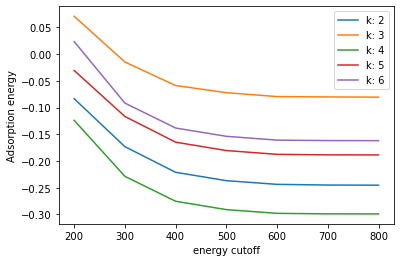

In [2]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
with open('project/Ru_energies_ex2d.pckl', 'rb') as f:
    Ru_energies = pickle.load(f)
with open('project/energies_abs_ex2d.pckl', 'rb') as f:
    energies_abs = pickle.load(f)
with open('project/HRu_energies_ex2d.pckl', 'rb') as f:
    HRu_energies = pickle.load(f)    


kpts = range(2,7) #number of kpoints
ecuts = range(200, 801, 100) #PW energy cut-off

# We plot the potential energy as a function of energy cutoff for each
# k-point sampling. The idea is to find the right tradeoff between
# computational cost and accuracy, i.e. the lowest parameters that
# give a good enough result.

for k in kpts:
    #HRu = []
    #Ru = []
    ads = []
    for ecut in ecuts:
        #Ru.append(Ru_energies[k][ecut])
        ads.append(energies_abs[k][ecut])
    plt.plot(ecuts, ads, label='k: '+str(k))
plt.xlabel('energy cutoff')
plt.ylabel('Adsorption energy')
plt.legend(loc='best')
plt.show()

In [13]:
%%writefile exam2d_contest_Cu110.py
import pickle
from ase.build import fcc110, add_adsorbate
from ase.lattice.cubic import FaceCenteredCubic
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW
from ase.io import write
from ase.build import molecule
import numpy as np
from ase.optimize import QuasiNewton
#from ase.optimize import BFGSLineSearch
from ase.optimize import LBFGS


nlayers = range(1,4) #number of slab layers
kpts = range(1,7) #number of kpoints
ecuts = range(200, 801, 100) #PW energy cut-off
#a_Cu = 3.62
vacuum = 10.0
height = 1.5 #height of adsorbate

# ------clean Ru slab-------
slab = fcc110('Cu', size=(2, 2, 3), vacuum=vacuum, periodic=True)
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

# Remember to visualize your structure
if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    add_adsorbate(slab=slab, adsorbate='H',
                  height=1.5, position='hollow')
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.



Cu_energies = {}
HCu_energies = {}
energies_abs = {}


for k in kpts:  
    
    Cu_energies[k] = {}
    HCu_energies[k] = {}
    energies_abs[k] = {}
    
    for ecut in ecuts:
        
        settings = {'h': 0.20,
            'mode': PW(ecut),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (k, k, 1),
            'symmetry': {'point_group': False},
            'xc': 'PBE'}
        
        calc = GPAW(txt='ex4-relax-Cu110_clean.txt', **settings)    
        slab.calc = calc
        parprint('Relaxing the clean surface slab!')
        
        relax = BFGS(slab, trajectory='ex4-relax-Cu110_clean.traj',
                    logfile='ex1-relax-Cu110_clean.log')
        relax.run(fmax=0.05)
        
        calc.write('ex4-Cu110_clean.gpw')  # We are going to need this gpw file later
        Cu_energies[k][ecut] = slab.get_potential_energy()
        
        atoms = slab.copy()  # Make a new clean copy
        
        add_adsorbate(slab=atoms, adsorbate='H',
                height=1.5, position='hollow')
        name = 'H-'+ 'hollow'
        
        calc = GPAW(txt='ex4-relax-Cu110_' + name + '.txt', **settings)
        
        atoms.calc = calc
        relax = BFGS(atoms, trajectory='ex4-relax-Cu110_' + name + '.traj',
                    logfile='ex4-relax-Cu110_' + name + '.log')
        relax.run(fmax=0.05)
        calc.write('ex4-Cu110_' + name + '.gpw')
        HCu_energies[k][ecut] = atoms.get_potential_energy()
        
        # Get energies for H2 we calculated earlier
        with paropen('energies_ex2.pckl', 'rb') as f:
            energies = pickle.load(f)
        
        # ads energies
        energies_abs[k][ecut] = HCu_energies[k][ecut] - Cu_energies[k][ecut] - 1/2. * energies['H2','PBE']
        
        
        with paropen('project/Cu_energies_ex2d_110.pckl', 'wb') as f:
            pickle.dump(Cu_energies, f)
        with paropen('project/HCu_energies_ex2d_110.pckl','wb') as f:
            pickle.dump(HCu_energies, f)
        with paropen('project/energies_abs_ex2d_110.pckl','wb') as f:
            pickle.dump(energies_abs, f)


Overwriting exam2d_contest_Cu110.py


In [1]:
!mq submit -R 24:8h exam2d_contest_Cu110.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
15021067 ./ exam2d_contest_Cu110.py 24:8h
1 task submitted


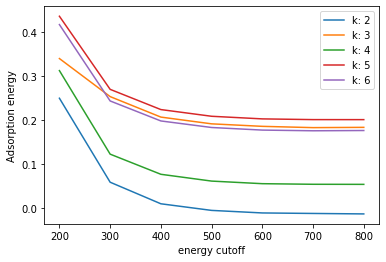

In [5]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
with open('project/Cu_energies_ex2d_110.pckl', 'rb') as f:
    Cu_energies = pickle.load(f)
with open('project/energies_abs_ex2d_110.pckl', 'rb') as f:
    energies_abs = pickle.load(f)
with open('project/HCu_energies_ex2d_110.pckl', 'rb') as f:
    HCu_energies = pickle.load(f)    

kpts = range(2,7) #number of kpoints
ecuts = range(200, 801, 100) #PW energy cut-off

# We plot the potential energy as a function of energy cutoff for each
# k-point sampling. The idea is to find the right tradeoff between
# computational cost and accuracy, i.e. the lowest parameters that
# give a good enough result.

for k in kpts:
    #HRu = []
    #Ru = []
    ads = []
    for ecut in ecuts:
        #Ru.append(Ru_energies[k][ecut])
        ads.append(energies_abs[k][ecut])
    plt.plot(ecuts, ads, label='k: '+str(k))
plt.xlabel('energy cutoff')
plt.ylabel('Adsorption energy')
plt.legend(loc='best')
plt.show()

In [15]:
%%writefile exam2d_contest_Ru110.py
import pickle
from ase.build import fcc110, add_adsorbate
from ase.lattice.cubic import FaceCenteredCubic
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW
from ase.io import write
from ase.build import molecule
import numpy as np
from ase.optimize import QuasiNewton
#from ase.optimize import BFGSLineSearch
from ase.optimize import LBFGS


nlayers = range(1,4) #number of slab layers
kpts = range(1,7) #number of kpoints
ecuts = range(200, 801, 100) #PW energy cut-off
a_Ru = 3.83
vacuum = 10.0
height = 1.5 #height of adsorbate

# ------clean Ru slab-------
slab = fcc110('Ru', a=a_Ru, size=(2, 2, 3), vacuum=vacuum, periodic=True)
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

# Remember to visualize your structure
if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    add_adsorbate(slab=slab, adsorbate='H',
                  height=1.5, position='hollow')
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.



Ru_energies = {}
HRu_energies = {}
energies_abs = {}


for k in kpts:  
    
    Ru_energies[k] = {}
    HRu_energies[k] = {}
    energies_abs[k] = {}
    
    for ecut in ecuts:
        
        settings = {'h': 0.20,
            'mode': PW(ecut),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (k, k, 1),
            'symmetry': {'point_group': False},
            'xc': 'PBE'}
        
        calc = GPAW(txt='ex4-relax-Ru110_clean.txt', **settings)    
        slab.calc = calc
        parprint('Relaxing the clean surface slab!')
        
        relax = BFGS(slab, trajectory='ex4-relax-Ru110_clean.traj',
                    logfile='ex4-relax-Ru110_clean.log')
        relax.run(fmax=0.05)
        
        calc.write('ex4-Ru110_clean.gpw')  # We are going to need this gpw file later
        Ru_energies[k][ecut] = slab.get_potential_energy()
        
        atoms = slab.copy()  # Make a new clean copy
        
        add_adsorbate(slab=atoms, adsorbate='H',
                height=1.5, position='hollow')
        name = 'H-'+ 'hollow'
        
        calc = GPAW(txt='ex4-relax-Ru110_' + name + '.txt', **settings)
        
        atoms.calc = calc
        relax = BFGS(atoms, trajectory='ex4-relax-Ru110_' + name + '.traj',
                    logfile='ex4-relax-Ru110_' + name + '.log')
        relax.run(fmax=0.05)
        calc.write('ex4-Ru110_' + name + '.gpw')
        HRu_energies[k][ecut] = atoms.get_potential_energy()
        
        # Get energies for H2 we calculated earlier
        with paropen('energies_ex2.pckl', 'rb') as f:
            energies = pickle.load(f)
        
        # ads energies
        energies_abs[k][ecut] = HRu_energies[k][ecut] - Ru_energies[k][ecut] - 1/2. * energies['H2','PBE']
        
        
        with paropen('project/Ru_energies_ex2d_Ru110.pckl', 'wb') as f:
            pickle.dump(Ru_energies, f)
        with paropen('project/HRu_energies_ex2d_Ru110.pckl','wb') as f:
            pickle.dump(HRu_energies, f)
        with paropen('project/energies_abs_ex2a_Ru110.pckl','wb') as f:
            pickle.dump(energies_abs, f)

Overwriting exam2d_contest_Ru110.py


In [2]:
!mq submit -R 24:8h exam2d_contest_Ru110.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
15021068 ./ exam2d_contest_Ru110.py 24:8h
1 task submitted


In [9]:
%%writefile exam2d_Cu111_absenergy.py
# Mathias
import pickle
from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW

# The fcc111 function returns an ASE Atoms object. It is a slab with
# the chosen size and vacuum in the z direction. The function also
# conveniently sets a tag on each layer of the slab; the top layer has
# tag=1, second layer tag=2 and so on.
slab = fcc111('Cu', size=(2, 2, 3), vacuum=10.0, periodic=True)

# Use the FixAtoms constraint to disallow any movement during
# relaxation of any atoms that has the property tag > 1.
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

# Remember to visualize your structure
if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    add_adsorbate(slab=slab, adsorbate='H',
                  height=1.5, position='fcc')
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.

energies_slab = {}


# First we relax the slab
settings = {'h': 0.20,
            'mode': PW(600),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (8, 8, 1),
            'symmetry': {'point_group': False},
            'xc': 'PBE'}

calc = GPAW(txt='relax-Cu111_clean.txt', **settings)

slab.calc = calc
parprint('Relaxing the clean surface slab!')

relax = BFGS(slab, trajectory='relax-Cu111_clean.traj',
             logfile='relax-Cu111_clean.log')
relax.run(fmax=0.05)

calc.write('Ru111_clean.gpw')  # We are going to need this gpw file later
energies_slab['clean'] = slab.get_potential_energy()

# Run through the configurations with a H adsorbate
for position in ['ontop', 'bridge', 'fcc', 'hcp']:
    parprint('Relaxing {}'.format(position))
    atoms = slab.copy()  # Make a new clean copy
    
    add_adsorbate(slab=atoms, adsorbate='H',
                  height=1.5, position=position)
    name = 'H-'+position
    
    calc = GPAW(txt='relax-Cu111_' + name + '.txt', **settings)
    
    atoms.calc = calc
    relax = BFGS(atoms, trajectory='relax-Cu111_' + name + '.traj',
                 logfile='relax-Cu111_' + name + '.log')
    relax.run(fmax=0.05)
    calc.write('Cu111_' + name + '.gpw')
    energies_slab[position] = atoms.get_potential_energy()

# Get energies for H2 we calculated earlier
with paropen('energies_ex2.pckl', 'rb') as f:
    energies = pickle.load(f)

# Calculate adsorption energies
e_ontop = energies_slab['ontop'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_bridge = energies_slab['bridge'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_fcc = energies_slab['fcc'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_hcp = energies_slab['hcp'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']

with paropen('ex3_results_Cu111.txt', 'w') as f:
    print('Ontop: {:.3f} eV\nBridge: {:.3f} eV\nfcc: {:.3f} eV\nhcp: {:.3f} eV'.format(e_ontop, e_bridge, e_fcc, e_hcp), file=f)

Overwriting exam2d_Cu111_absenergy.py


In [10]:
!mq submit -R 24:6h exam2d_Cu111_absenergy.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
15020713 ./ exam2d_Cu111_absenergy.py 24:6h
1 task submitted


In [7]:
%%writefile exam2d_Cu110_absenergy.py
# Mathias
import pickle
from ase.build import fcc110, add_adsorbate
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW

# The fcc111 function returns an ASE Atoms object. It is a slab with
# the chosen size and vacuum in the z direction. The function also
# conveniently sets a tag on each layer of the slab; the top layer has
# tag=1, second layer tag=2 and so on.
slab = fcc110('Cu', size=(2, 2, 3), vacuum=10.0, periodic=True)

# Use the FixAtoms constraint to disallow any movement during
# relaxation of any atoms that has the property tag > 1.
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

# Remember to visualize your structure
if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    add_adsorbate(slab=slab, adsorbate='H',
                  height=1.5, position='hollow')
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.

energies_slab = {}


# First we relax the slab
settings = {'h': 0.20,
            'mode': PW(600),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (8, 8, 1),
            'symmetry': {'point_group': False},
            'xc': 'PBE'}

calc = GPAW(txt='relax-Cu110_clean.txt', **settings)

slab.calc = calc
parprint('Relaxing the clean surface slab!')

relax = BFGS(slab, trajectory='relax-Cu110_clean.traj',
             logfile='relax-Cu110_clean.log')
relax.run(fmax=0.05)

calc.write('Cu110_clean.gpw')  # We are going to need this gpw file later
energies_slab['clean'] = slab.get_potential_energy()

# Run through the configurations with a H adsorbate
for position in ['ontop','longbridge','shortbridge','hollow']:
    parprint('Relaxing {}'.format(position))
    atoms = slab.copy()  # Make a new clean copy
    
    add_adsorbate(slab=atoms, adsorbate='H',
                  height=1.5, position=position)
    name = 'H-'+position
    
    calc = GPAW(txt='relax-Cu110_' + name + '.txt', **settings)
    
    atoms.calc = calc
    relax = BFGS(atoms, trajectory='relax-Cu110_' + name + '.traj',
                 logfile='relax-Cu110_' + name + '.log')
    relax.run(fmax=0.05)
    calc.write('Cu110_' + name + '.gpw')
    energies_slab[position] = atoms.get_potential_energy()

# Get energies for H2 we calculated earlier
with paropen('energies_ex2.pckl', 'rb') as f:
    energies = pickle.load(f)

# Calculate adsorption energies
e_ontop = energies_slab['ontop'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_bridge = energies_slab['longbridge'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_fcc = energies_slab['shortbridge'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_hcp = energies_slab['hollow'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']

with paropen('ex3_results_Cu110.txt', 'w') as f:
    print('Ontop: {:.3f} eV\nlongbridge: {:.3f} eV\nshortbridge: {:.3f} eV\nhollow: {:.3f} eV'.format(e_ontop, e_bridge, e_fcc, e_hcp), file=f)

Overwriting exam2d_Cu110_absenergy.py


In [8]:
!mq submit -R 24:6h exam2d_Cu110_absenergy.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
15020712 ./ exam2d_Cu110_absenergy.py 24:6h
1 task submitted


In [5]:
%%writefile exam2d_Ru111_absenergy.py
# Mathias
import pickle
from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW

# The fcc111 function returns an ASE Atoms object. It is a slab with
# the chosen size and vacuum in the z direction. The function also
# conveniently sets a tag on each layer of the slab; the top layer has
# tag=1, second layer tag=2 and so on.
slab = fcc111('Ru', a=3.83, size=(2, 2, 3), vacuum=10.0, periodic=True)

# Use the FixAtoms constraint to disallow any movement during
# relaxation of any atoms that has the property tag > 1.
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

# Remember to visualize your structure
if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    add_adsorbate(slab=slab, adsorbate='H',
                  height=1.5, position='fcc')
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.

energies_slab = {}


# First we relax the slab
settings = {'h': 0.20,
            'mode': PW(600),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (8, 8, 1),
            'symmetry': {'point_group': False},
            'xc': 'PBE'}

calc = GPAW(txt='relax-Ru111_clean.txt', **settings)

slab.calc = calc
parprint('Relaxing the clean surface slab!')

relax = BFGS(slab, trajectory='relax-Ru111_clean.traj',
             logfile='relax-Ru111_clean.log')
relax.run(fmax=0.05)

calc.write('Ru111_clean.gpw')  # We are going to need this gpw file later
energies_slab['clean'] = slab.get_potential_energy()

# Run through the configurations with a H adsorbate
for position in ['ontop', 'bridge', 'fcc', 'hcp']:
    parprint('Relaxing {}'.format(position))
    atoms = slab.copy()  # Make a new clean copy
    
    add_adsorbate(slab=atoms, adsorbate='H',
                  height=1.5, position=position)
    name = 'H-'+position
    
    calc = GPAW(txt='relax-Ru111_' + name + '.txt', **settings)
    
    atoms.calc = calc
    relax = BFGS(atoms, trajectory='relax-Ru111_' + name + '.traj',
                 logfile='relax-Ru111_' + name + '.log')
    relax.run(fmax=0.05)
    calc.write('Ru111_' + name + '.gpw')
    energies_slab[position] = atoms.get_potential_energy()

# Get energies for H2 we calculated earlier
with paropen('energies_ex2.pckl', 'rb') as f:
    energies = pickle.load(f)

# Calculate adsorption energies
e_ontop = energies_slab['ontop'] - energies_slab['clean'] -  1/2. * energies['H2', 'PBE']
e_bridge = energies_slab['bridge'] - energies_slab['clean'] -  1/2. * energies['H2', 'PBE']
e_fcc = energies_slab['fcc'] - energies_slab['clean'] -  1/2. * energies['H2', 'PBE']
e_hcp = energies_slab['hcp'] - energies_slab['clean'] -  1/2. * energies['H2', 'PBE']

with paropen('ex3_results_Ru111.txt', 'w') as f:
    print('Ontop: {:.3f} eV\nBridge: {:.3f} eV\nfcc: {:.3f} eV\nhcp: {:.3f} eV'.format(e_ontop, e_bridge, e_fcc, e_hcp), file=f)

Overwriting exam2d_Ru111_absenergy.py


In [6]:
!mq submit -R 24:6h exam2d_Ru111_absenergy.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
15020711 ./ exam2d_Ru111_absenergy.py 24:6h
1 task submitted


In [3]:
%%writefile exam2d_Ru110_absenergy.py
# Mathias
import pickle
from ase.build import fcc110, add_adsorbate
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW

# The fcc111 function returns an ASE Atoms object. It is a slab with
# the chosen size and vacuum in the z direction. The function also
# conveniently sets a tag on each layer of the slab; the top layer has
# tag=1, second layer tag=2 and so on.
slab = fcc110('Ru', a=3.81 , size=(2, 2, 3), vacuum=10.0, periodic=True)

# Use the FixAtoms constraint to disallow any movement during
# relaxation of any atoms that has the property tag > 1.
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

# Remember to visualize your structure
if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    add_adsorbate(slab=slab, adsorbate='H',
                  height=1.5, position='hollow')
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.

energies_slab = {}


# First we relax the slab
settings = {'h': 0.20,
            'mode': PW(600),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (8, 8, 1),
            'symmetry': {'point_group': False},
            'xc': 'PBE'}

calc = GPAW(txt='relax-Ru110_clean.txt', **settings)

slab.calc = calc
parprint('Relaxing the clean surface slab!')

relax = BFGS(slab, trajectory='relax-Ru110_clean.traj',
             logfile='relax-Ru110_clean.log')
relax.run(fmax=0.05)

calc.write('Ru110_clean.gpw')  # We are going to need this gpw file later
energies_slab['clean'] = slab.get_potential_energy()

# Run through the configurations with a H adsorbate
for position in ['ontop','longbridge','shortbridge','hollow']:
    parprint('Relaxing {}'.format(position))
    atoms = slab.copy()  # Make a new clean copy
    
    add_adsorbate(slab=atoms, adsorbate='H',
                  height=1.5, position=position)
    name = 'H-'+position
    
    calc = GPAW(txt='relax-Ru110_' + name + '.txt', **settings)
    
    atoms.calc = calc
    relax = BFGS(atoms, trajectory='relax-Ru110_' + name + '.traj',
                 logfile='relax-Ru110_' + name + '.log')
    relax.run(fmax=0.05)
    calc.write('Ru110_' + name + '.gpw')
    energies_slab[position] = atoms.get_potential_energy()

# Get energies for H2 we calculated earlier
with paropen('energies_ex2.pckl', 'rb') as f:
    energies = pickle.load(f)

# Calculate adsorption energies
e_ontop = energies_slab['ontop'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_bridge = energies_slab['longbridge'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_fcc = energies_slab['shortbridge'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_hcp = energies_slab['hollow'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']

with paropen('ex3_results_Ru110.txt', 'w') as f:
    print('Ontop: {:.3f} eV\nlongbridge: {:.3f} eV\nshortbridge: {:.3f} eV\nhollow: {:.3f} eV'.format(e_ontop, e_bridge, e_fcc, e_hcp), file=f)

Overwriting exam2d_Ru110_absenergy.py


In [4]:
!mq submit -R 24:6h exam2d_Ru110_absenergy.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
15020710 ./ exam2d_Ru110_absenergy.py 24:6h
1 task submitted


In [4]:
!cat ex3_results_Ru111.txt

Ontop: -0.001 eV
Bridge: -0.617 eV
fcc: -0.618 eV
hcp: -0.581 eV


In [5]:
!cat ex3_results_Ru110.txt

Ontop: 0.071 eV
longbridge: -0.243 eV
shortbridge: -0.545 eV
hollow: -0.372 eV


In [6]:
!cat ex3_results_Cu111.txt

Ontop: 0.402 eV
Bridge: -0.055 eV
fcc: -0.199 eV
hcp: -0.186 eV


In [7]:
!cat ex3_results_Cu110.txt

Ontop: 0.524 eV
longbridge: 0.002 eV
shortbridge: -0.110 eV
hollow: 0.169 eV


In [17]:
!mq ls

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
id       folder name                             res.         age state         time 
──────── ────── ──────────────────────────────── ───── ────────── ─────── ────────── 
14995313 ./     exam2b_supercell_1.py            24:2d 4:01:11:56 done       6:34:45 
14995809 ./     exam2b_supercell_1.py            24:2d 4:00:07:29 done       6:43:01 
14996

## 2.5

In [60]:
%%writefile exam2e_CuRu111_absenergysites.py
import pickle
from ase.build import fcc111, add_adsorbate
from ase.lattice.cubic import FaceCenteredCubic
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW
from ase.io import write
from ase.build import molecule
from ase.visualize import view
import numpy as np

a_Ru = 3.83
vacuum = 10.0
height = 1.5 #height of adsorbate

# ------clean Ru slab-------
slab = fcc111('Ru', a=a_Ru, size=(2, 2, 3), vacuum=vacuum, periodic=True)
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

#slab.center(vacuum=vacuum)

view(slab)

slab.symbols[8] = 'Cu'
slab.symbols[9] = 'Cu'
slab.symbols[10] = 'Cu'
slab.symbols[11] = 'Cu'

view(slab)


energies_slab = {}


# First we relax the slab
settings = {'h': 0.20,
            'mode': PW(600),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (8, 8, 1),
            'symmetry': {'point_group': False},
            'xc': 'PBE'}

calc = GPAW(txt='relax-CuRu111_clean.txt', **settings)

slab.calc = calc
parprint('Relaxing the clean surface slab!')

relax = BFGS(slab, trajectory='relax-CuRu111_clean.traj',
             logfile='relax-CuRu111_clean.log')
relax.run(fmax=0.05)

calc.write('CuRu111_clean.gpw')  # We are going to need this gpw file later
energies_slab['clean'] = slab.get_potential_energy()

# Run through the configurations with a H adsorbate
for position in ['ontop', 'bridge', 'fcc', 'hcp']:
    parprint('Relaxing {}'.format(position))
    atoms = slab.copy()  # Make a new clean copy
    
    add_adsorbate(slab=atoms, adsorbate='H',
                  height=1.5, position=position)
    name = 'H-'+position
    
    calc = GPAW(txt='relax-CuRu111_' + name + '.txt', **settings)
    
    atoms.calc = calc
    relax = BFGS(atoms, trajectory='relax-CuRu111_' + name + '.traj',
                 logfile='relax-CuRu111_' + name + '.log')
    relax.run(fmax=0.05)
    calc.write('CuRu111_' + name + '.gpw')
    energies_slab[position] = atoms.get_potential_energy()

# Get energies for H2 we calculated earlier
with paropen('energies_ex2.pckl', 'rb') as f:
    energies = pickle.load(f)

# Calculate adsorption energies
e_ontop = energies_slab['ontop'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_bridge = energies_slab['bridge'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_fcc = energies_slab['fcc'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_hcp = energies_slab['hcp'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']

with paropen('ex5_results_CuRu111.txt', 'w') as f:
    print('Ontop: {:.3f} eV\nBridge: {:.3f} eV\nfcc: {:.3f} eV\nhcp: {:.3f} eV'.format(e_ontop, e_bridge, e_fcc, e_hcp), file=f)

Overwriting exam2e_CuRu111_absenergysites.py


In [18]:
!mq submit -R 24:6h exam2e_CuRu111_absenergysites.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
15020120 ./ exam2e_CuRu111_absenergysites.py 24:6h
1 task submitted


In [2]:
%%writefile exam2e_CuRu110_absenergysites.py
import pickle
from ase.build import fcc110, add_adsorbate
from ase.lattice.cubic import FaceCenteredCubic
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW
from ase.io import write
from ase.build import molecule
from ase.visualize import view
import numpy as np

a_Ru = 3.83
vacuum = 10.0
height = 1.5 #height of adsorbate

# ------clean Ru slab-------
slab = fcc110('Ru', a=a_Ru, size=(2, 2, 3), vacuum=vacuum, periodic=True)
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

#slab.center(vacuum=vacuum)

view(slab)

slab.symbols[8] = 'Cu'
slab.symbols[9] = 'Cu'
slab.symbols[10] = 'Cu'
slab.symbols[11] = 'Cu'

view(slab)


energies_slab = {}


# First we relax the slab
settings = {'h': 0.20,
            'mode': PW(600),
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (8, 8, 1),
            'symmetry': {'point_group': False},
            'xc': 'PBE'}

calc = GPAW(txt='relax-CuRu110_clean.txt', **settings)

slab.calc = calc
parprint('Relaxing the clean surface slab!')

relax = BFGS(slab, trajectory='relax-CuRu110_clean.traj',
             logfile='relax-CuRu110_clean.log')
relax.run(fmax=0.05)

calc.write('CuRu110_clean.gpw')  # We are going to need this gpw file later
energies_slab['clean'] = slab.get_potential_energy()

# Run through the configurations with a H adsorbate
for position in ['ontop','longbridge','shortbridge','hollow']:
    parprint('Relaxing {}'.format(position))
    atoms = slab.copy()  # Make a new clean copy
    
    add_adsorbate(slab=atoms, adsorbate='H',
                  height=1.5, position=position)
    name = 'H-'+position
    
    calc = GPAW(txt='relax-CuRu110_' + name + '.txt', **settings)
    
    atoms.calc = calc
    relax = BFGS(atoms, trajectory='relax-CuRu110_' + name + '.traj',
                 logfile='relax-CuRu110_' + name + '.log')
    relax.run(fmax=0.05)
    calc.write('CuRu110_' + name + '.gpw')
    energies_slab[position] = atoms.get_potential_energy()

# Get energies for H2 we calculated earlier
with paropen('energies_ex2.pckl', 'rb') as f:
    energies = pickle.load(f)

# Calculate adsorption energies
e_ontop = energies_slab['ontop'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_bridge = energies_slab['longbridge'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_fcc = energies_slab['shortbridge'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']
e_hcp = energies_slab['hollow'] - energies_slab['clean'] - 1/2. * energies['H2', 'PBE']

with paropen('ex5_results_CuRu110.txt', 'w') as f:
    print('Ontop: {:.3f} eV\nlongbridge: {:.3f} eV\nshortbridge: {:.3f} eV\nhollow: {:.3f} eV'.format(e_ontop, e_bridge, e_fcc, e_hcp), file=f)

Overwriting exam2e_CuRu110_absenergysites.py


In [3]:
!mq submit -R 24:6h exam2e_CuRu110_absenergysites.py

No such task: 14934486, FAILED
No such task: 14934483, FAILED
No such task: 14934397, FAILED
No such task: 14934371, FAILED
No such task: 14936930, FAILED
No such task: 14948814, FAILED
No such task: 14948978, FAILED
No such task: 14969195, FAILED
No such task: 14979011, FAILED
No such task: 14979014, FAILED
No such task: 14992687, FAILED
No such task: 14996150, FAILED
No such task: 15001229, FAILED
No such task: 15001230, FAILED
No such task: 15001249, FAILED
No such task: 15010103, FAILED
No such task: 15010111, FAILED
No such task: 15001854, FAILED
No such task: 15001865, FAILED
No such task: 15020056, FAILED
No such task: 15020059, FAILED
15020392 ./ exam2e_CuRu110_absenergysites.py 24:6h
1 task submitted


In [12]:
!cat ex5_results_CuRu111.txt

Ontop: 0.804 eV
Bridge: -0.270 eV
fcc: -0.271 eV
hcp: -0.172 eV


In [2]:
!cat ex5_results_CuRu110.txt

Ontop: 0.104 eV
longbridge: -0.337 eV
shortbridge: -0.314 eV
hollow: -0.299 eV


In [44]:
import pickle
from ase.build import fcc110, add_adsorbate
from ase.lattice.cubic import FaceCenteredCubic
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW
from ase.io import write
from ase.build import molecule
from ase.visualize import view
import numpy as np

a_Ru = 3.83
vacuum = 10.0
height = 1.5 #height of adsorbate

# ------clean Ru slab-------
slab = fcc110('Ru', a=a_Ru, size=(2, 2, 3), vacuum=vacuum, periodic=True)
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

#slab.center(vacuum=vacuum)

view(slab)

slab.symbols[8] = 'Cu'
slab.symbols[9] = 'Cu'
slab.symbols[10] = 'Cu'
slab.symbols[11] = 'Cu'

view(slab)

In [8]:
import pickle
from ase.build import fcc111, add_adsorbate
from ase.lattice.cubic import FaceCenteredCubic
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac, PW
from ase.io import write
from ase.build import molecule
from ase.visualize import view
import numpy as np

a_Ru = 3.83
vacuum = 10.0
height = 1.5 #height of adsorbate

# ------clean Ru slab-------
slab = fcc111('Ru', a=a_Ru, size=(2, 2, 3), vacuum=vacuum, periodic=True)
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag == 3])
slab.set_constraint(c)

#slab.center(vacuum=vacuum)

add_adsorbate(slab=slab, adsorbate='H',
            height=1.5, position='hcp')

view(slab)